#Document Classification using ML models

We will use a dataset on 2225 BBC news articles for this activity. The article text and its category are given in our dataset.
Upload the "bbc-news.csv" dataset (download it from elearn) to your session before proceeding.

In [ ]:
#import the dataset
import numpy as np
import pandas as pd
df = pd.read_csv('bbc-news.csv')
df['category_id'] = df.category.factorize()[0] #we need this later
df.head(5)

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


<Axes: xlabel='category', ylabel='count'>

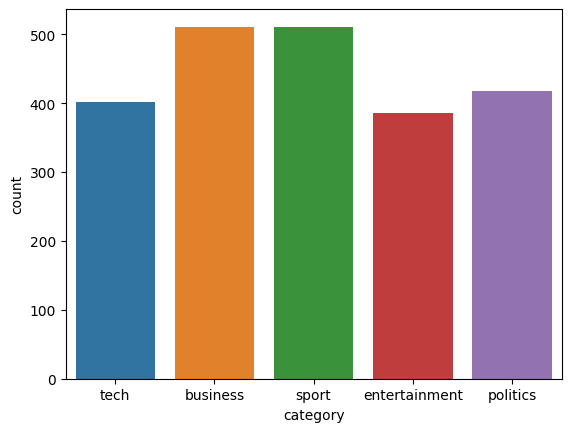

In [ ]:
# frequency of articles in each category
import seaborn as sb
sb.countplot(data=df, x='category')

## Text pre-processing

*TfidfVectorizer* lower-cases all words, removes punctuations and stopwords, tokenizes the documents, and derives the tf-idf document-term matrix.


In [ ]:
X=df.text
from sklearn.feature_extraction.text import TfidfVectorizer
# only keep words that have min frequency=5 in our corpus (min_df=4)
tfidf = TfidfVectorizer(min_df=4, encoding='latin-1', ngram_range=(1, 1), stop_words='english')
X_tfidf = tfidf.fit_transform(df.text).toarray()
Y = df.category_id
X_tfidf.shape

(2225, 10617)

In [ ]:
# Let's take a look at an article and its tokens from the tf-idf matrix
print(df.text[2]),
tfidf.inverse_transform(X_tfidf[2])

tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i th

ValueError: ignored

In [ ]:
# number of tokens in each document (review) of our corpus
num_tokens = [np.count_nonzero(tokens) for tokens in X_tfidf]
max(num_tokens) #longest document

901

In [ ]:
# number of words in our vocabulary
num_words=len(tfidf.vocabulary_)
num_words

10617

## Split the data into test/train
We split the tranformed data (i.e, the tf-idf doc-term matrix) into testing and training set. I keep a small part for the testing set here.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.20,random_state=123)

## ML models for text classification
We will use Logistic Regression, multinomial Naive Bayes, and SVM for this multiclass classification problem.
We train all models using k-fold Cross validation.

For more details on *Multinomial Naive Bayes*, see https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes and
https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# prepare models
models = []
models.append(('LogisticReg', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('MultinomialNB', MultinomialNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy' #metric we want to compare

for name, model in models:
	kfold = model_selection.KFold(n_splits=5,shuffle=True, random_state=0)
	cv_results = model_selection.cross_val_score(model, X_tfidf, Y, cv=kfold, scoring=scoring)
  #cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot model comparison
fig = plt.figure()
fig.suptitle('Comparing Text classification models: ' +scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LogisticReg: 0.977528 (0.009534)


KeyboardInterrupt: ignored

### Question 1
Which model has a better accuracy in predicting the article's category?

Answer: The SVM model.

## Evaluate Logistic Regression classifier's performance


In [ ]:
from sklearn.linear_model import LogisticRegression
# Logistic regression
model_LogReg = LogisticRegression(random_state=0)
model_LogReg.fit(X_train, y_train)

#y_pred_proba = model_LogReg.predict_proba(X_test)
y_pred = model_LogReg.predict(X_test)

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Accuracy: 0.9775280898876404
Balanced Acc.: 0.9764618409113821


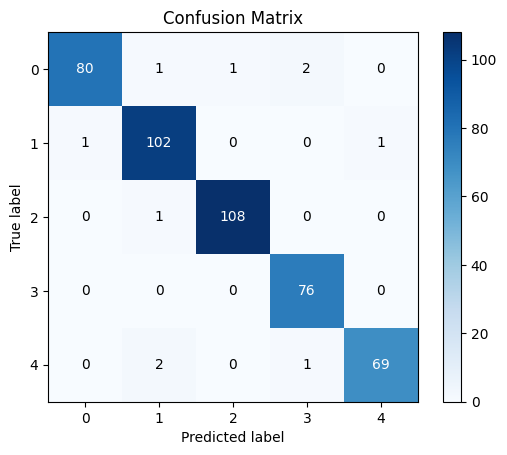

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))

From earlier we know:
tech=0,
business=1,
sport=2,
entertainment=3,
politics=4

Seems a Logistic Regression does a pretty good job.

## Label a new article using the logistic regression model

In [ ]:
# label a new review using our model
new_article= ['nobody knows where he is or what he does']
#process new review into doc-term matrix
X_new=tfidf.transform(new_article)

print(model_LogReg.predict_proba(X_new)) #predict class probabilities
print(model_LogReg.predict(X_new)) #predict outcome class


[[0.1868541  0.20188459 0.31619153 0.17101924 0.12405054]]
[2]


### Question 2
Which category does the logistic regression assign this new article to?

Answer: Sports category and also to business category but with low probability.

# Document Classification using word embeddings and RNNs (LSTM/GRU)


In [ ]:
import tensorflow.keras as tk
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional,RNN
tk.__version__

'2.12.0'

## Preprocessing text data for RNN
To use Recurrent neural network architectures for text classification, we need to pre-process text data little differently from what we did above.
* We create a vocabulary by tokenizing all document in our corpus.
* Then, we sequence each document into integer-tokens using the derived vocabulary.
* To correctly feed each document input to the RNN, each sequenced document has to have the same length. Therefore, we pad/truncate documents.
* We use an embedding layer to convert the integer-vectors into real-valued vectors (more details in section below)
* The output of the embedding layer is fed into our Recurrent NN


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer #removes punctuations and lower-cases all words before tokenizing
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Tokenizing, sequencing, padding

In [ ]:
num_words=10000 #number of words to keep in vocabulary, most common words are kept
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

In [ ]:
len(tokenizer.word_index) # total number of unique words in our corpus
#tokenizer.word_index # run to see what integer is assigned to each word after tokenization

29726

In [ ]:
# sequencing our text data (tokenizing based)
X_tokens=tokenizer.texts_to_sequences(X)

In [ ]:
# some values we need for the next step
num_tokens= np.array([np.count_nonzero(tokens) for tokens in X_tokens]) #number of tokens in each document
max_tokens=max(num_tokens)
max_tokens,np.mean(num_tokens),np.std(num_tokens)

(4236, 376.8494382022472, 231.1309902079681)

In [ ]:
# pad the token sequence for each document so that all documents are of equal length
max_tokens=1000
X_tokens_pad = pad_sequences(X_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')
X_tokens_pad.shape

(2225, 1000)

In [ ]:
# let's see what happened to a single document at each step
print(X[17]) #the textual data
print(X_tokens[17]) #the tokenized sequence
print(X_tokens_pad[17]) #the padded sequence

connors boost for british tennis former world number one jimmy connors is planning a long-term relationship with the lawn tennis association to help unearth the next tim henman.  the american spent three days at the lta s annual elite performance winter camp in la manga earlier this week.  britain has the right attitude   said connors.  the more involved i can be with the lta  the better.  a short-term arrangement is just confusing. the kids will ask:  what am i doing there    lta chief executive  john crowther  added:  the relationship that jimmy s already started to develop with the coaches and the players has said to us that we d like some more of it.  we want to use jimmy for a number of weeks a year and we hope this is the beginning of a good long-term relationship.   the camp played host to more than 30 leading senior and junior players  including greg rusedski  arvind parmar and anne keothavong.  la manga is an amazing site to take a bunch of kids who want to be the best   said 

## Splitting the processed data into train/test

In [ ]:
# split processed data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tokens_pad, Y, test_size=0.2,random_state=123)

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((1780, 1000), (445, 1000), (1780,))

## Building a Recurrent neural network
The first layer is an embedding layer that converts the integer-tokens into vector values.
This is needed since the integer-tokens (X_tokens) can have values between 0 and 1800 (for our vocabulary of 1800 words), but the RNN cannot work with such wide range. The learned vector values range from -1 to 1.

The embedding-layer is trained as part of the RNN and learns to map words with similar meaning to similar embedding vectors. We will try an example below.

In [ ]:
embedding_size=100 #size of the embedding vector

model_NN = tk.models.Sequential()

model_NN.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

#model_NN.add(LSTM(units=32,return_sequences=True,dropout=0.2)) # add an LSTM layer
#model_NN.add(Dropout(0.2))

model_NN.add(LSTM(units=16,dropout=0.2)) # add last LSTM layer
#model_NN.add(GRU(units=16,dropout=0.2)) #add last GRU layer

# for sequences other than time series, an RNN model can sometimes perform better if it processes a sequence both forwards and backwards.
# For example, to predict the next word in a sentence it is useful to have the context around the word.
# the Bidirectional wrapper adds such layers.
#model_NN.add(Bidirectional(LSTM(units=16,dropout=0.2)))

model_NN.add(Dropout(0.2))

# the output layers has 5 units since we have 5 outcome categories
# we use the softmax function to get a probability will for each outcome category
model_NN.add(Dense(5, activation='softmax'))

optimizer=tk.optimizers.Adam() # selecting the optimizer

# compiling the model
model_NN.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,
                 metrics=['accuracy'])

model_NN.summary() # model overview

In [ ]:
# make sure the input data can be feed to the NN
model_NN.predict(X_train[:3])

1/1 [==============================] - 1s 763ms/step


array([[0.20042518, 0.20042181, 0.20049454, 0.19636673, 0.2022917 ],
       [0.19880791, 0.19855481, 0.20214961, 0.20542769, 0.19505996],
       [0.19868267, 0.2030854 , 0.20089205, 0.19937795, 0.19796187]],
      dtype=float32)

In [ ]:
# train the RNN model (NOTE! it can take a while!)
history = model_NN.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=30, verbose=1)
#history = model_NN.fit(X_train, y_train,validation_split=0.2,epochs=10, verbose=1)

Epoch 1/30
 4/56 [=>............................] - ETA: 25s - loss: 0.0275 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label="training")
plt.plot(history.history['val_accuracy'],label="validation")
plt.xlabel("epoch")
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label="training")
plt.plot(history.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.title('Loss')
plt.legend()
plt.show()

### Question 3
Do we need to run the model for more epochs?

Answer: No.

## Evaluate  RNN model on the test set

In [ ]:
y_pred=np.argmax(model_NN.predict(X_test),axis=-1)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))
#tech=0
#business=1
#sport=2
#entertainment=3
#politics=4

### Question 4
Compare the RNN model with the Logistic Regression Classifier in terms of accuracy. Does the RNN model perform better?

Answer: No, RNN model doesn't perform better than logistic regression in terms of accuracy.

## Classify a new input/article using the RNN
Let's see how our classifier performs on a new article.

In [ ]:
new_review= ['nobody knows who he is or what he does']
new_sequence=tokenizer.texts_to_sequences(new_review) # tokenize and sequence
new_seq_pad=pad_sequences(new_sequence, maxlen=max_tokens,padding='pre') # pad it
new_seq_pad;

In [ ]:
model_NN.predict(new_seq_pad) # predict probability
#np.argmax(model_NN.predict(X),axis=-1) #for multiclass outcomes
#(model_NN.predict(new_seq_pad)>0.5).astype('int32') #for binary outcomes

In [ ]:
# let's see
new_article= ['In a recent study led by the University of Bristol, scientists have shown how to simultaneously \
harness multiple forms of regulation in living cells to strictly control gene expression and open new avenues \
for improved biotechnologies. Engineered microbes are increasingly being used to enable the sustainable and \
clean production of chemicals, medicines and much more. To make this possible, bioengineers must control when \
specific sets of genes are turned on and off to allow for careful regulation of the biochemical processes involved.']
new_sequence=tokenizer.texts_to_sequences(new_article) # tokenize and sequence
new_seq_pad=pad_sequences(new_sequence, maxlen=max_tokens,padding='pre') # pad it
new_seq_pad;

In [ ]:
model_NN.predict(new_seq_pad) # predict probability

### Question 5
Which category does the RNN model assign this new article to?

Answer: Entertainment category.

## Extract word embeddings
Earlier we mentioned word embeddings and that we have an embedding layer which learns how to map words (in the form of integer-tokens) to vectors as we train the neural network.

The distance between two word vectors indicate their similarity and we can derive these vectors for any word in our vocabulary from the embedding layer.

We will use the cosine distance between two words. Cosine values can range from [-1,1], so the distance can range frmo 0 to 2 (in our complex vector space):
* cosine distance close to 0: two words have the same meaning
* cosine distance close to 2: two words are antonyms

For more details on cosine similarity, see https://en.wikipedia.org/wiki/Cosine_similarity

In [ ]:
# extract the embedding layer from the RNN architecture
embedding_weights=model_NN.get_layer('layer_embedding').get_weights()[0]

# vector for a word in our vocabulary
print(tokenizer.word_index['service']) # integer for word in our vocabulary
# word vector representation as learned in the embedding layer
embedding_weights[tokenizer.word_index['service']]

In [ ]:
# let's calculate distance between any two words in our vocabulary
from scipy.spatial.distance import cdist
float(cdist([embedding_weights[tokenizer.word_index['tree']]],
            [embedding_weights[tokenizer.word_index['sky']]],
            metric='cosine'))